In [67]:
import pyhepmc as hep
import os
import os
import json
import argparse
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

In [68]:
file = "tag_1_pythia8_events.hepmc"
pid = [1000015]
status = [62,1,2]
toGeV = 1

staus=[]
daughter_particles = []
events=[]



In [71]:
with hep.open(file) as f:
    while True:
        evt = f.read()
        if not evt:
            break
        event ={}
        for particle in evt.particles:
            if abs(particle.pid) not in pid:
                continue
#            if particle.status not in status:
                continue
            stau ={}
            particlemom = particle.momentum
#            print('particlemom', particlemom)
            stau["eta"] = particlemom.eta() 
            stau["phi"] = particlemom.phi() 
            stau["pt" ] = particlemom.pt()/toGeV 
            stau["p"  ] = particlemom.length()/toGeV 
            stau["m"  ] = particlemom.m()/toGeV 
            stau["betagamma"]  = stau["p"]/stau["m"]
            # to get the production vertex and position
            prod_vertex = particle.production_vertex
            prod_vector = prod_vertex.position
            #record prod vertex
            stau["prod_x"] = prod_vector.x
            stau["prod_y"] = prod_vector.y
            stau["prod_z"] = prod_vector.z
            stau["prod_t"] = prod_vector.t
        #if stau decays:
            decayvtx = particle.end_vertex
            if(decayvtx) :
                 fourvec = decayvtx.position
                 products = decayvtx.particles_out
#                 print("number of decay products is",len(products))
#                 print("status of stau is",particle.status)
#                 print("Decay location is: x",fourvec.x,", y",fourvec.y,", z",fourvec.z,", t",fourvec.t)
                 #record daughter particles
                 i = 0
                 for prod in products:
                     daughter_particle = {}
                     i += 1
                     daughter_mom = prod.momentum
                     daughter_vertex=prod.production_vertex
                     daughter_vector=daughter_vertex.position
#                     print("momentum of ", i, "daughter particle is", daughter_mom)
                     daughter_particle["eta"] = daughter_mom.eta() 
                     daughter_particle["phi"] = daughter_mom.phi() 
                     daughter_particle["pt" ] = daughter_mom.pt()/toGeV 
                     daughter_particle["p"  ] = daughter_mom.length()/toGeV 
                     daughter_particle["x"] = daughter_vector.x
                     daughter_particle["y"] = daughter_vector.y
                     daughter_particle["z"] = daughter_vector.z
                     daughter_particle["t"] = daughter_vector.t
                     daughter_particle["pid"]=prod.pid

                     daughter_particles.append(daughter_particle)
                     
                 #record decay position
                 stau["decay_lxy"]        =  fourvec.perp() 
                 stau["decay_x"]          =  fourvec.x 
                 stau["decay_y"]          =  fourvec.y 
                 stau["decay_z"]          =  fourvec.z 
                 stau["decay_t"]          =  fourvec.t
                


         #else it is stable:  
            else:
                print("stable")
                stau["lxy"] = 999999
                stau["decay_z"]   = 999999  
                stau["decay_t"] = 999999 
                stau["decay_x"] =  999999
                stau["decay_y"] = 999999
            stau["lifetime"]= stau["decay_t"]-stau["prod_t"]
        staus.append(stau)

        

In [72]:
p = np.array([x['p'] for x in staus]) 
pt = np.array([x['pt'] for x in staus]) 
eta = np.array([x['eta'] for x in staus]) 
phi = np.array([x['phi'] for x in staus]) 
m = np.array([x['m'] for x in staus]) 
prod_x = np.array([x['prod_x'] for x in staus]) 
prod_y = np.array([x['prod_y'] for x in staus])
prod_z = np.array([x['prod_z'] for x in staus])
prod_t = np.array([x['prod_t'] for x in staus])
decay_x = np.array([x['decay_x'] for x in staus])
decay_y = np.array([x['decay_y'] for x in staus])
decay_z = np.array([x['decay_z'] for x in staus])
decay_t = np.array([x['decay_t'] for x in staus])
betagamma = np.array([x['betagamma'] for x in staus])
c = 3*10**8
lifetime = np.array([x['lifetime']/c for x in staus])
#daughter particles:
dau_p = np.array([x['p'] for x in daughter_particles]) 
dau_pt = np.array([x['pt'] for x in daughter_particles]) 
dau_eta = np.array([x['eta'] for x in daughter_particles]) 
dau_phi = np.array([x['phi'] for x in daughter_particles]) 
dau_x = np.array([x['x'] for x in daughter_particles]) 
dau_y = np.array([x['y'] for x in daughter_particles]) 
dau_z = np.array([x['z'] for x in daughter_particles]) 
dau_t = np.array([x['t'] for x in daughter_particles]) 
dau_r = np.array([np.sqrt(x['x']**2+x['y']**2) for x in daughter_particles])
dau_pid = np.array([x['pid'] for x in daughter_particles]) 



In [73]:
def plot2DHistogram(datax, datay, bins=100, norm="log", label=""):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="plasma")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel, fontsize=15)

    plt.show()
def plot1DHistogram(data,bins,scale='linear',label=""):
    

    
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    
    ax.hist(data, bins=bins)
    
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.yscale(scale)
    plt.show()

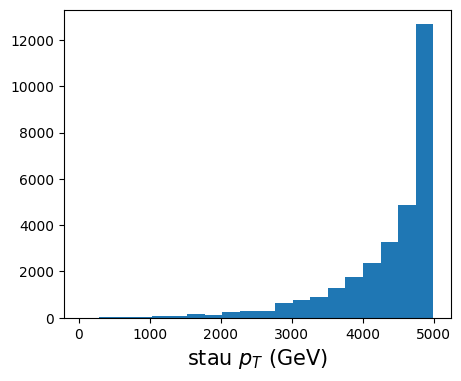

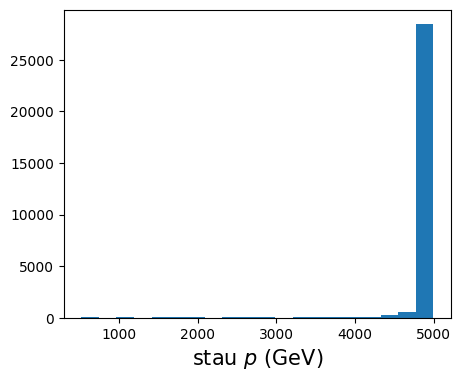

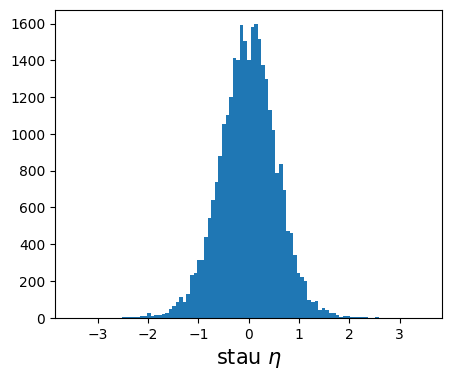

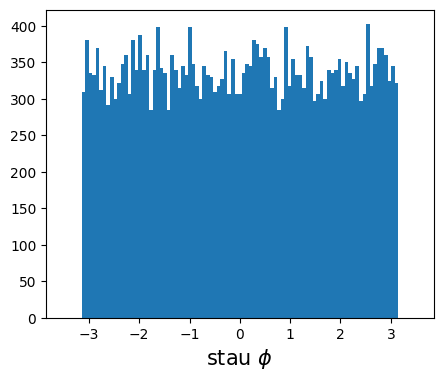

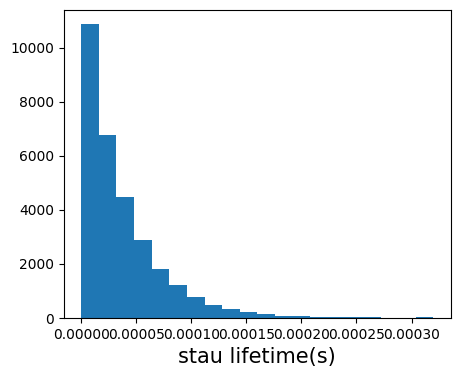

In [74]:
plot1DHistogram(pt     , bins=20  , label=";stau $p_{T}$ (GeV)")
plot1DHistogram(p     , bins=20  , label=";stau $p$ (GeV)")
plot1DHistogram(eta    , np.linspace(-3.5,3.5,100), label=";stau $\eta$")
plot1DHistogram(phi    , np.linspace(-3.5,3.5,100), label=";stau $\phi$")
plot1DHistogram(lifetime, bins=20  , label=";stau lifetime(s)")


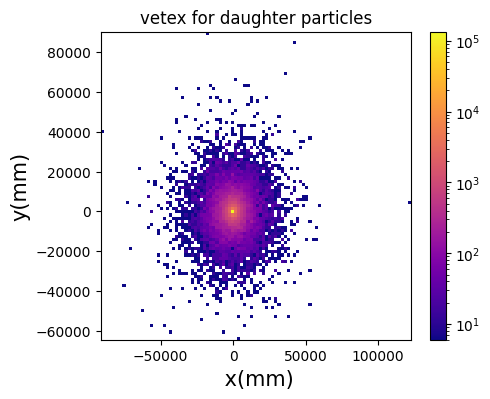

In [75]:
plot2DHistogram(dau_x,dau_y,bins=100,label ="vetex for daughter particles; x(mm);y(mm)")



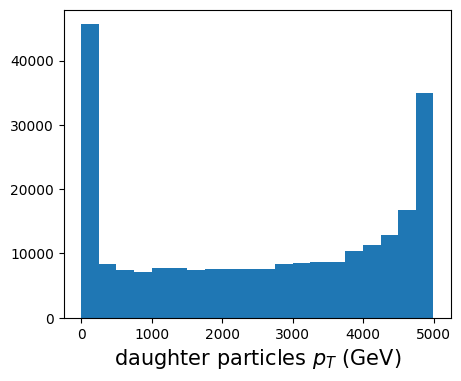

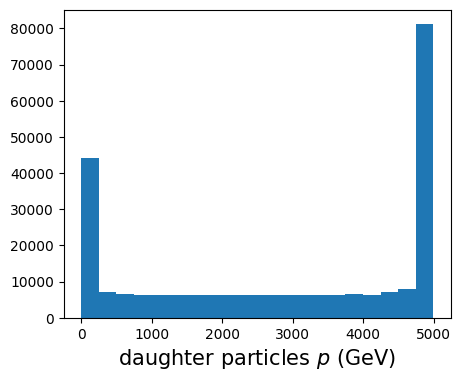

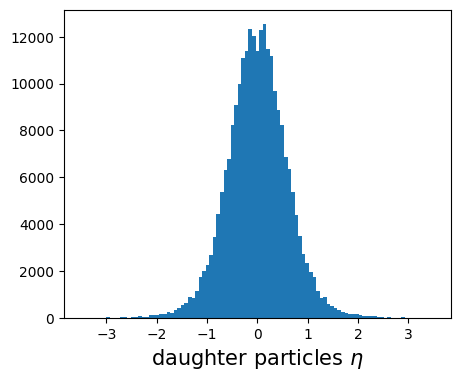

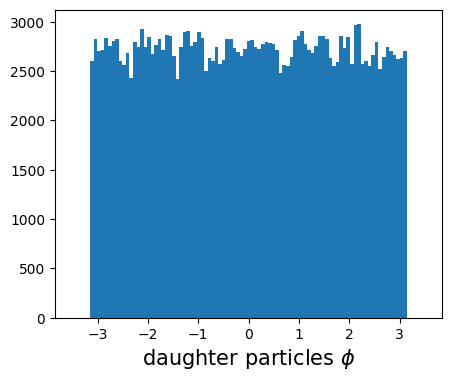

In [79]:
plot1DHistogram(dau_pt     , bins=20  , label=";daughter particles $p_{T}$ (GeV)")
plot1DHistogram(dau_p     , bins=20  , label=";daughter particles $p$ (GeV)")
plot1DHistogram(dau_eta    , np.linspace(-3.5,3.5,100), label=";daughter particles $\eta$")
plot1DHistogram(dau_phi    , np.linspace(-3.5,3.5,100), label=";daughter particles $\phi$")


In [55]:
#check if lifetime and velocity in lab frame makes sense
v = c*np.tanh(np.arcsinh(betagamma))
dist = np.sqrt(decay_x**2+decay_y**2+decay_z**2)
vt = v*lifetime
print(max(dist-vt))


2.9103830456733704e-11


array([2.99891454e+08, 2.99891454e+08, 2.99891454e+08, ...,
       2.99891454e+08, 2.99891328e+08, 2.99891453e+08])